# Saving, Loading Qiskit Machine Learning Models and Continuous Training

In this tutorial we will show how to save and load Qiskit machine learning models. Ability to save a model is very important, especially when a significant amount of time is invested in training a model on a real hardware. Also, we will show how to resume training of the previously saved model.

In this tutorial we will cover how to:

* Generate a simple dataset, split it into training/test datasets and plot them
* Train and save a model
* Load a saved model and resume training
* Evaluate performance of models
* PyTorch hybrid models

First off, we start from the required imports. We'll heavily use SciKit-Learn on the data preparation step. In the next cell we also fix a random seed for reproducibility purposes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils import QuantumInstance, algorithm_globals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from qiskit_machine_learning.algorithms.classifiers import VQC

from IPython.display import clear_output

algorithm_globals.random_seed = 42

path = 'qiskit-runtime'
# Check whether the specified
# path exists or not
Exist = os.path.exists(path)


#Si no existe el path clonaremos el repositorio en ese path, si ya existe no haremos nada.
if Exist == False: 
    print('Clonando Repositorio...')
    !git clone https://github.com/Qiskit-Partners/qiskit-runtime.git
    
else: 
    print('No se clonará el repositorio debido a que ya existe en el sistema')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


No se clonará el repositorio debido a que ya existe en el sistema


In [2]:
sys.path.insert(0, 'qiskit-runtime')

We will be using two quantum simulators. We'll start training on the QASM simulator then will resume training on the statevector simulator. The approach shown in this tutorial can be used to train a model on a real hardware available on the cloud and then re-use the model for inference on a local simulator.

In [3]:
qi_qasm = QuantumInstance(
    Aer.get_backend("aer_simulator"),
    shots=1024,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

qi_sv = QuantumInstance(
    Aer.get_backend("aer_simulator_statevector"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

## 1. Prepare a dataset

Next step is to prepare a dataset. Here, we generate some data in the same way as in other tutorials. The difference is that we apply some transformations to the generated data. We generates `40` samples, each sample has `2` features, so our features is an array of shape `(40, 2)`. Labels are obtained by summing up features by columns and if the sum is more than `1` then this sample is labeled as `1` and `0` otherwise.

In [4]:
# Load CSV File

url = "https://raw.githubusercontent.com/Qiskit-Partners/qiskit-runtime/main/qiskit_runtime/qka/aux_file/dataset_graph7.csv" # Make sure the url is the raw version of the file on GitHub

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(url,header= None)

#df.loc[df[10] == 2, 10] = 0

df = df.sample(frac=1)

#columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,14]

#df = df[columns]

data = df.values

features = data[:,:-1]

labels = data[:,-1]

In [5]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,-0.100006,0.002431,0.244218,0.126870,-0.063891,-0.085588,0.072490,0.042986,-0.052714,0.019754,-0.159314,-0.409991,-0.199615,0.053845,-1.0
87,-0.028166,-1.490271,-1.697566,0.106625,-1.536164,-1.538329,-1.356331,-1.514472,-0.109491,-1.800178,-0.121627,-1.651143,-1.955366,-0.123157,-1.0
8,-0.085208,-0.026512,-0.026404,-0.003274,-0.281643,0.035630,-0.304897,0.240393,0.057127,-1.551001,0.396600,-0.150969,-1.420543,-0.039464,1.0
20,-0.236777,0.238615,-0.173778,-1.355794,-0.267929,-1.644752,-1.939455,-1.868695,-1.400942,-1.688003,0.360651,-0.007626,-0.043301,-1.553362,1.0
33,-0.097343,-0.004679,-0.023547,0.005101,-0.133145,-1.598626,0.277875,0.048134,-0.162593,-0.066978,-1.749605,0.262330,-0.263479,0.166594,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.413746,-1.439224,-1.606212,0.246367,-1.672731,0.002269,-1.316527,-1.262398,-0.177720,-1.813590,0.013138,-1.618524,-1.859687,-0.249520,-1.0
11,-1.703818,0.132671,-1.517564,0.106002,-0.025376,-1.625499,0.141323,-0.187485,-0.137023,-1.640929,-0.048722,-0.351289,-0.133078,0.188405,-1.0
32,-0.210908,-1.555893,0.110789,0.117722,-1.903635,0.061494,-0.379975,-1.353484,-0.049300,0.153115,0.274087,-1.725856,0.181325,-0.070543,1.0
55,-0.046122,-1.491968,-1.557514,-0.053209,-1.565675,-0.006934,-1.436743,-1.483034,-0.195879,-0.058220,-1.749475,-1.367204,-0.033779,0.119220,-1.0


Then, we scale down our features into a range of `[0, 1]` by applying `MinMaxScaler` from SciKit-Learn. Model training convergence is better when this  transformation is applied.

In [6]:
features = MinMaxScaler().fit_transform(features)
features.shape

(128, 14)

Let's take a look at the features of the first `5` samples of our dataset after the transformation.

In [7]:
features[0:5, :]

array([[0.89237106, 0.85378575, 1.        , 0.86837599, 0.87451888,
        0.8359086 , 0.84953655, 0.84966713, 0.7900492 , 0.90548646,
        0.70728287, 0.63135759, 0.82171471, 0.86201386],
       [0.92688524, 0.18425306, 0.03329686, 0.85819733, 0.18764222,
        0.15080209, 0.26579656, 0.19830586, 0.76214331, 0.01556676,
        0.72283955, 0.17515698, 0.        , 0.77736638],
       [0.89948032, 0.84080382, 0.86527315, 0.80294369, 0.77292847,
        0.89307445, 0.69535623, 0.93222675, 0.84403693, 0.13741039,
        0.93675415, 0.72656441, 0.25030436, 0.81739081],
       [0.8266625 , 0.95972311, 0.79190392, 0.12293992, 0.77932674,
        0.10061317, 0.027563  , 0.05016239, 0.1273882 , 0.07041871,
        0.921915  , 0.77925174, 0.89487172, 0.09340039],
       [0.89365062, 0.85059677, 0.86669552, 0.80715434, 0.84220912,
        0.12236626, 0.93344567, 0.85182019, 0.736043  , 0.86307573,
        0.05083923, 0.87847746, 0.79182551, 0.91593339]])

We choose `VQC` or Variational Quantum Classifier as a model we will train. This model, by default, takes one-hot encoded labels, so we have to transform the labels that are in the set of `{0, 1}` into one-hot representation. We employ SciKit-Learn for this transformation as well. Please note that the input array must be reshaped to `(num_samples, 1)` first. The `OneHotEncoder` encoder does not work with 1D arrays and our labels is a 1D array. In this case a user must decide either an array has only one feature(our case!) or has one sample. Also, by default the encoder returns sparse arrays, but for dataset plotting it is easier to have dense arrays, so we set `sparse` to `False`. 

In [8]:
labels = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))
labels.shape

(128, 2)

Let's take a look at the labels of the first `5` labels of the dataset. The labels should be one-hot encoded.

In [9]:
labels[0:5, :]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

Now we split our dataset into two parts: a training dataset and a test one. As a rule of thumb, 80% of a full dataset should go into a training part and 20% into a test one. Our training dataset has `30` samples. The test dataset should be used only once, when a model is trained to verify how well the model behaves on unseen data. We employ `train_test_split` from SciKit-Learn.

In [10]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)
train_features.shape

(45, 14)

Now it is time to see how our dataset looks like. Let's plot it.

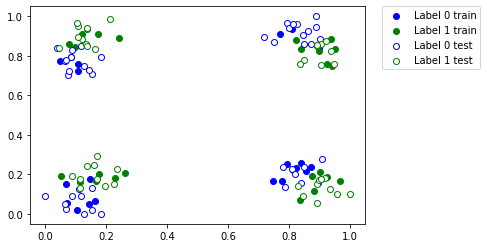

In [11]:
def plot_dataset():
    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 0), 0],
        train_features[np.where(train_labels[:, 0] == 0), 1],
        marker="o",
        color="b",
        label="Label 0 train",
    )
    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 1), 0],
        train_features[np.where(train_labels[:, 0] == 1), 1],
        marker="o",
        color="g",
        label="Label 1 train",
    )

    plt.scatter(
        test_features[np.where(test_labels[:, 0] == 0), 0],
        test_features[np.where(test_labels[:, 0] == 0), 1],
        marker="o",
        facecolors="w",
        edgecolors="b",
        label="Label 0 test",
    )
    plt.scatter(
        test_features[np.where(test_labels[:, 0] == 1), 0],
        test_features[np.where(test_labels[:, 0] == 1), 1],
        marker="o",
        facecolors="w",
        edgecolors="g",
        label="Label 1 test",
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

plot_dataset()
plt.show()

On the plot above we see:

* Solid <span style="color:blue">blue</span> dots are the samples from the training dataset labeled as `0`
* Empty <span style="color:blue">blue</span> dots are the samples from the test dataset labeled as `0`
* Solid <span style="color:green">green</span> dots are the samples from the training dataset labeled as `1`
* Empty <span style="color:green">green</span> dots are the samples from the test dataset labeled as `1`

We'll train our model using solid dots and verify it using empty dots.

## 2. Train a model and save it

We'll train our model in two steps. On the first step we train our model in `20` iterations.

In [12]:
maxiter = 20

Create an empty array for callback to store values of the objective function.

In [13]:
objective_values = []

We re-use a callback function from the Neural Network Classifier & Regressor tutorial to plot iteration versus objective function value with some minor tweaks to plot objective values at each step.

In [14]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(_, objective_value):
    clear_output(wait=True)
    objective_values.append(objective_value)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")

    stage1_len = np.min((len(objective_values), maxiter))
    stage1_x = np.linspace(1, stage1_len, stage1_len)
    stage1_y = objective_values[:stage1_len]

    stage2_len = np.max((0, len(objective_values) - maxiter))
    stage2_x = np.linspace(maxiter, maxiter + stage2_len - 1, stage2_len)
    stage2_y = objective_values[maxiter : maxiter + stage2_len]

    plt.plot(stage1_x, stage1_y, color="orange")
    plt.plot(stage2_x, stage2_y, color="purple")
    plt.show()


plt.rcParams["figure.figsize"] = (12, 6)

As mentioned above we train a `VQC` model and set `COBYLA` as an optimizer with a chosen value of the `maxiter` parameter. Then we evaluate performance of the model to see how well it was trained. Then we save this model for a file. On the second step we load this model and will continue to work with it.

Here, we manually construct an ansatz to fix an initial point where to start optimization from.

In [15]:
original_optimizer = COBYLA(maxiter=maxiter)

num_features = features.shape[1]
ansatz = RealAmplitudes(num_features)
#initial_point = np.asarray([0.5] * ansatz.num_parameters)

We create a model and set a quantum instance to the QASM simulator we created earlier.

In [16]:

original_classifier = VQC(
    optimizer=original_optimizer, callback=callback_graph, quantum_instance=qi_qasm,
    ansatz = ansatz,
    num_qubits = 14)

In [17]:
print(ansatz.initial_state)

None


Now it is time to train the model.

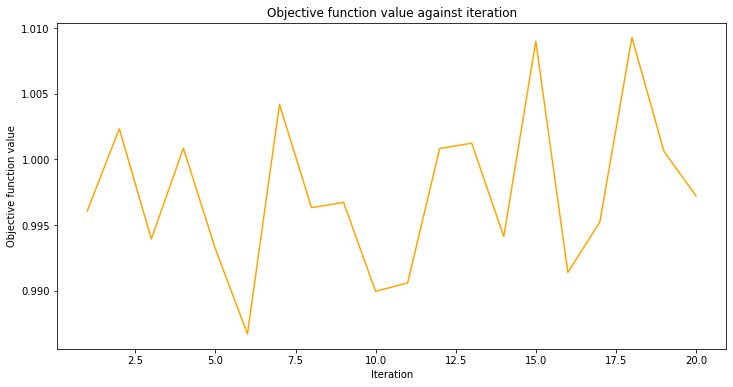

In [18]:
original_classifier.fit(train_features, train_labels)

Let's see how well our model performs after the first step of training.

In [19]:
print("Train score", original_classifier.score(train_features, train_labels))
print("Test score ", original_classifier.score(test_features, test_labels))

Train score 0.5777777777777777
Test score  0.4457831325301205


Next, we save the model. You may choose any file name you want. Please note that the `save` method does not append an extension if it is not specified in the file name.

In [20]:
original_classifier.save("vqc_classifier.model")

## 3. Load a model and continue training

To load a model a user have to call a class method `load` of the corresponding model class. In our case it is `VQC`. We pass the same file name we used in the previous section where we saved our model.

In [21]:
loaded_classifier = VQC.load("vqc_classifier.model")

Next, we want to alter the model in a way it can be trained further and on another simulator. To do so, we set the `warm_start` property. When it is set to `True` and `fit()` is called again the model uses weights from previous fit to start a new fit. We also set quantum instance of the underlying network to the statevector simulator we created in the beginning of the tutorial. Finally, we create and set a new optimizer with `maxiter` is set to `80`, so the total number of iterations is `100`.

In [22]:
loaded_classifier.warm_start = True
loaded_classifier.neural_network.quantum_instance = qi_sv
loaded_classifier.optimizer = COBYLA(maxiter=80)

Now we continue training our model from the state we finished in the previous section.

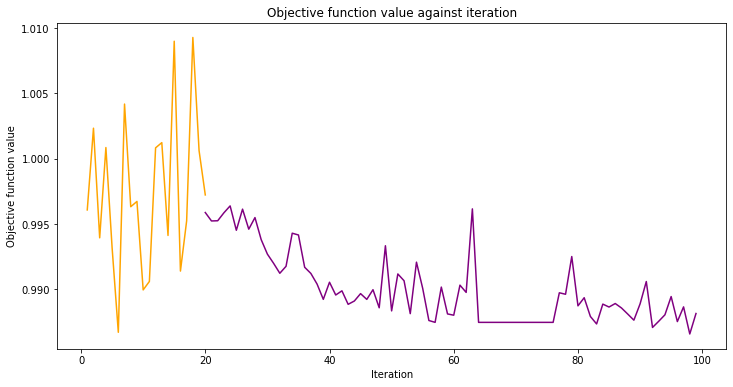

In [23]:
loaded_classifier.fit(train_features, train_labels)

In [24]:
print("Train score", loaded_classifier.score(train_features, train_labels))
print("Test score", loaded_classifier.score(test_features, test_labels))

Train score 0.5777777777777777
Test score 0.4457831325301205


Let's see which data points were misclassified. First, we call `predict` to infer predicted values from the training and test features.

In [25]:
train_predicts = loaded_classifier.predict(train_features)
test_predicts = loaded_classifier.predict(test_features)

Plot the whole dataset and the highlight the points that were classified incorrectly.

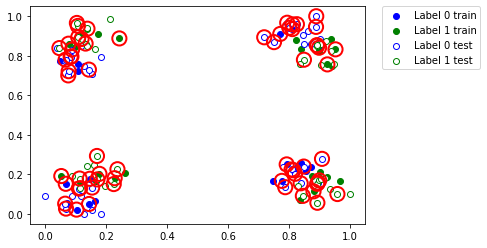

In [26]:
# return plot to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

plot_dataset()

# plot misclassified data points
plt.scatter(
    train_features[np.all(train_labels != train_predicts, axis=1), 0],
    train_features[np.all(train_labels != train_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)
plt.scatter(
    test_features[np.all(test_labels != test_predicts, axis=1), 0],
    test_features[np.all(test_labels != test_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)

So, if you have a large dataset or a large model you can train it in multiple steps as shown in this tutorial.

## 4. PyTorch hybrid models

To save and load hybrid models, when using the TorchConnector, follow the PyTorch recommendations of saving and loading the models. For more details please refer to the PyTorch Connector tutorial [here](https://qiskit.org/documentation/machine-learning/tutorials/05_torch_connector.html) where a short snippet shows how to do it.

Take a look at this pseudo-like code to get the idea:
```python
# create a QNN and a hybrid model
qnn = create_qnn()
model = Net(qnn)
# ... train the model ...

# save the model
torch.save(model.state_dict(), "model.pt")

# create a new model
new_qnn = create_qnn()
loaded_model = Net(new_qnn)
loaded_model.load_state_dict(torch.load("model.pt"))
```

In [27]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright